# load L3 regional data derive statistics and store

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt

import pynsitu as pin
crs = pin.maps.crs

import swotlib as sb

import gstools as gs
from xhistogram.xarray import histogram

In [5]:
def load_l3(version, pass_number=None, cycle=None):
    if pass_number is None:
        _pass = ""
    else:
        _pass = f"{pass_number}_"
    core_path = os.path.join(sb.root_path, "cswot/swot/l3_"+version)
    zarr = os.path.join(core_path, _pass+"concatenated.zarr")
    if os.path.isdir(zarr):
        D = xr.open_dataset(zarr)
        return D
    files = sorted(glob(os.path.join(core_path, _pass+"*.zarr")))
    #if cycle is not None:
    #    files = [f if _pass+f"{cycle}" for f in files]
    D = [_open(f) for f in files]
    D = {t: ds for ds, t in D}
    return D

def _open(f, engine="zarr"):
    ds = xr.open_dataset(f, engine=engine)
    ds["cycle_number"] = ds["cycle_number"].median()
    t = pd.to_datetime(ds["time"].mean().values)
    return ds, t

def _plot(*args, **kwargs):
    n = len(args)
    fig, axes = plt.subplots(1,n)
    da.plot(**kwargs)
    ax.set_aspect("equal")
    return ax

#_plot()

In [56]:
version = "v0.3"
version = "v1.0"
#version = "v1.0.1"

pass_number = 3
#pass_number = 16

# build concatenated field
if True:
    D = load_l3(version, pass_number=pass_number)
    ds = xr.concat(D.values(), "cycle_number")
    zarr = os.path.join(sb.root_path, "cswot/swot/l3_"+version+f"/{pass_number}_concatenated.zarr")
    ds.to_zarr(zarr, mode="w")

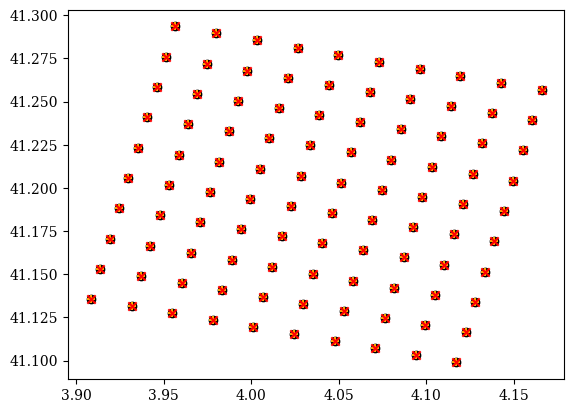

In [61]:
# check coordinates
_D = list(D.values())[:4]
ds = _D[0]

fig, ax = plt.subplots()

di = 10
line_offset = 100 # v1.0
#line_offset = 1000 # v1.0.1

_ds = _D[0].sel(num_lines=slice(line_offset,line_offset+di), num_pixels=slice(0,di))
ax.scatter(_ds.longitude, _ds.latitude, c="k")

_ds = _D[1].sel(num_lines=slice(line_offset,line_offset+di), num_pixels=slice(0,di))
ax.scatter(_ds.longitude, _ds.latitude, c="orange", marker="+")

_ds = _D[2].sel(num_lines=slice(line_offset,line_offset+di), num_pixels=slice(0,di))
ax.scatter(_ds.longitude, _ds.latitude, c="red", marker="x")

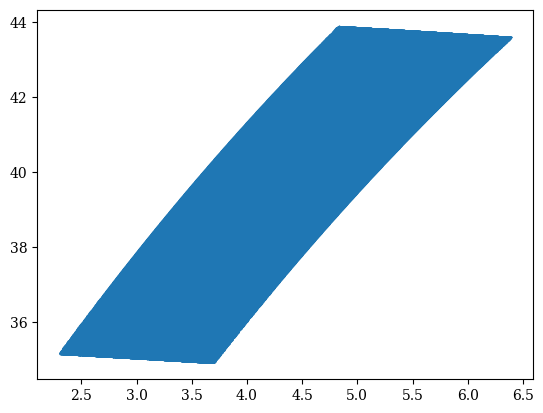

In [55]:
#ds.plot.scatter("longitude", "latitude", s=10, c="k")
fig, ax = plt.subplots(1,1)
ax.scatter(ds.longitude, ds.latitude, s=.1)

In [4]:
ds = load_l3(version)

ds["ssha_karin_2_xcal"] = ds["ssha_karin_2"] + ds["duacs_xcal"]

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


---

## plot snapshot

In [5]:
list(ds.variables)

['ancillary_surface_classification_flag',
 'cross_track_distance',
 'cvl_beta_angle',
 'cvl_flag_val',
 'cvl_flag_val_outliers',
 'cvl_mean_dynamic_topography_cnes_cls_22',
 'cvl_mean_sea_surface_cnes_22_hybrid',
 'cvl_nadir_flag_val_mle4_1hz',
 'cvl_nadir_ssha_mle4_1hz',
 'cvl_ocean_tide_fes_2022',
 'cvl_sea_state_bias_cor_model',
 'cvl_ssha_reference',
 'cycle_number',
 'dac',
 'distance_to_coast',
 'duacs_Barotrop_demo1',
 'duacs_Equatorial_gravity_east_demo1',
 'duacs_Equatorial_gravity_west_demo1',
 'duacs_Equatorial_tiw_demo1',
 'duacs_GeoLongScale_demo1',
 'duacs_GeoSmallScale_demo1',
 'duacs_LongWavelenghtError_swon_demo1',
 'duacs_LongWavelenghtError_swonc_demo1',
 'duacs_bias_karin_nadir',
 'duacs_distance_to_coast',
 'duacs_editing_flag',
 'duacs_editing_flag_bak',
 'duacs_land_sea_mask',
 'duacs_nadir_orbit_error',
 'duacs_phase_screen',
 'duacs_phase_screen_orbit',
 'duacs_phase_screen_static',
 'duacs_relative_vorticity',
 'duacs_speed_meridional',
 'duacs_speed_meridiona

In [6]:
for v in ["ssha_karin_2", "duacs_ssha_karin_2", "duacs_ssha_karin_2_calibrated", "duacs_ssha_karin_2_filtered"]:
    print("-- " +v)
    print(ds[v].attrs["comment"])

-- ssha_karin_2
Sea surface height anomaly from the KaRIn measurement = ssh_karin_2 - mean_sea_surface_cnescls - solid_earth_tide - ocean_tide_fes – internal_tide_hret - pole_tide - dac.
-- duacs_ssha_karin_2
deduced from KaRIn measurement
-- duacs_ssha_karin_2_calibrated
Height of the sea surface anomaly with all corrections applied but without editing.
-- duacs_ssha_karin_2_filtered
Height of the sea surface anomaly with all corrections applied and denoised using Unet model.


In [7]:
_ds = ds.sel(cycle_number=490)

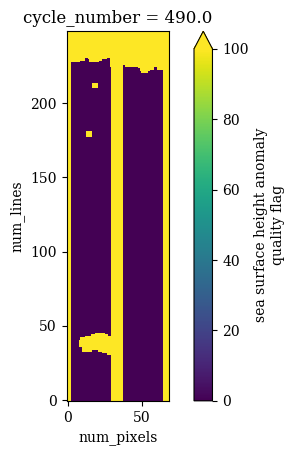

In [8]:
_plot(_ds["ssha_karin_2_qual"], vmax=100)

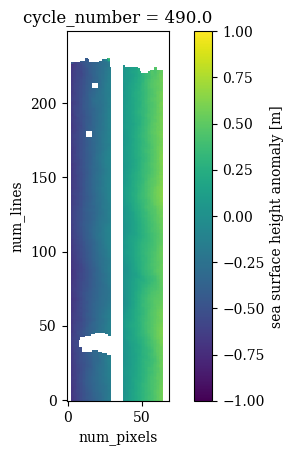

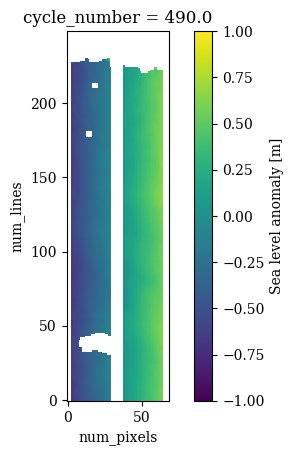

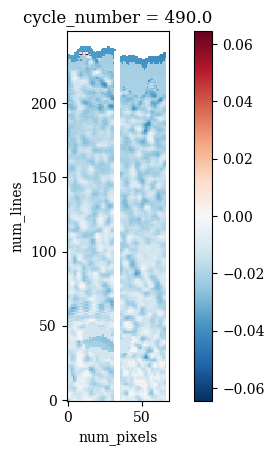

In [9]:
mask = (_ds["ssha_karin_2_qual"]<50)
_plot(_ds["ssha_karin_2"].where(mask), vmin=-1, vmax=1)
_plot(_ds["duacs_ssha_karin_2"].where(mask), vmin=-1, vmax=1)
_plot(_ds["ssha_karin_2"] - _ds["duacs_ssha_karin_2"])

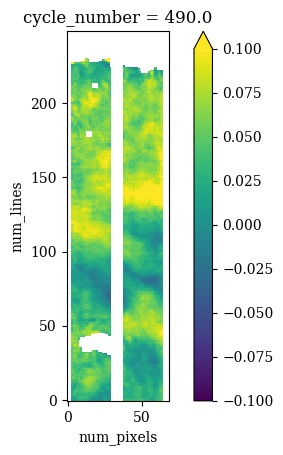

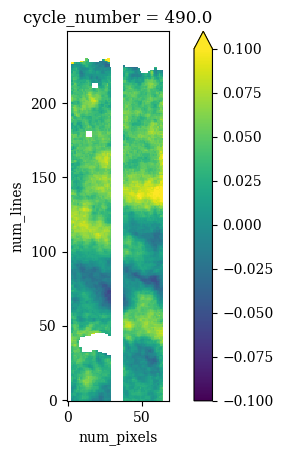

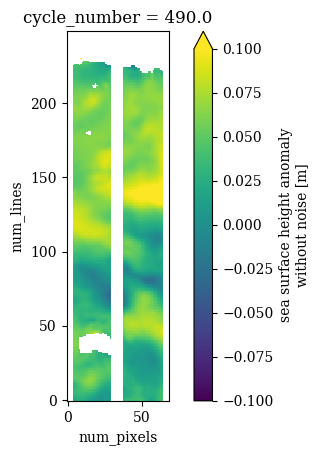

In [10]:
_plot((_ds["duacs_ssha_karin_2"]+_ds["duacs_xcal"]).where(mask), vmin=-.1, vmax=.1)
_plot((_ds["ssha_karin_2"]+_ds["duacs_xcal"]).where(mask), vmin=-.1, vmax=.1)
_plot(_ds["duacs_ssha_karin_2_filtered"], vmin=-.1, vmax=.1)

---

## check timeseries

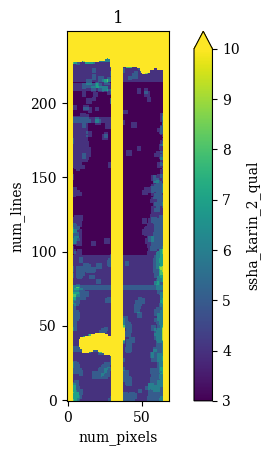

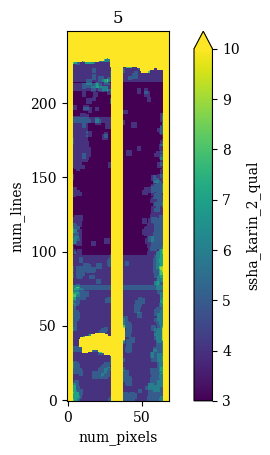

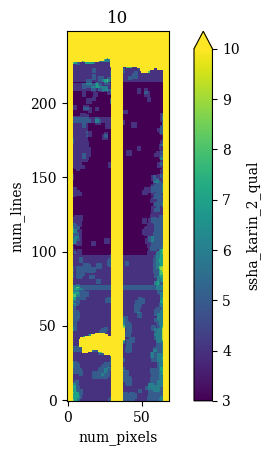

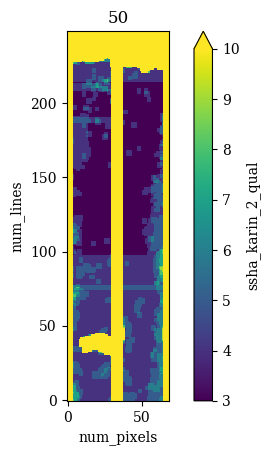

In [24]:
# inspect mask
# mask seems to be 0 or large values
for level in [1, 5, 10, 50]:
    mask = xr.where(ds["ssha_karin_2_qual"]<level, 0, 1)
    count = mask.sum("cycle_number")
    ax = _plot(count, vmax=10)
    ax.set_title(level)

In [ ]:
# try detecting presence of outliers based on difference between median and max

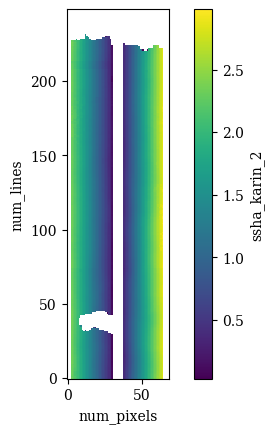

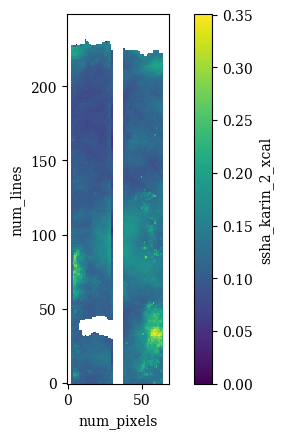

In [25]:
_dsm = ds.median("cycle_number").compute()
mask = (ds["ssha_karin_2_qual"]<1)
for v in ["ssha_karin_2", "ssha_karin_2_xcal"]:
    da = np.abs(ds[v] - _dsm[v]).where(mask).max("cycle_number")
    _plot(da)

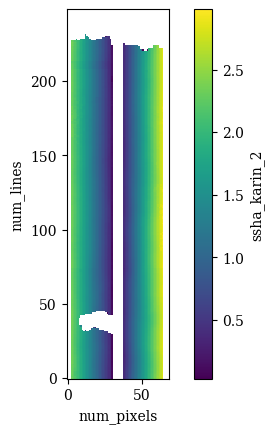

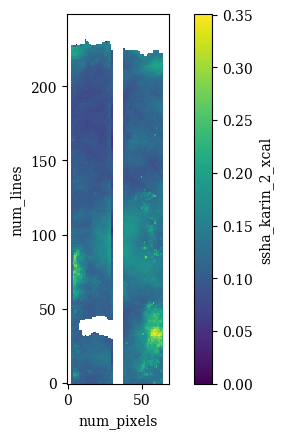

In [37]:
def _plot(*args, figkw={}, **kwargs):
    n = len(args)
    fig, axes = plt.subplots(1,n, **figkw)
    if n==1:
        axes = [axes]
    for da, ax in zip(args, axes):
        da.plot(ax=ax, **kwargs)
        ax.set_aspect("equal")
    return ax


_dsm = ds.median("cycle_number").compute()
mask = (ds["ssha_karin_2_qual"]<1)
for v in ["ssha_karin_2", "ssha_karin_2_xcal"]:
    da = np.abs(ds[v] - _dsm[v]).where(mask).max("cycle_number")
    _plot(da)

In [ ]:
fig, ax = plt.subplots(1,1)
for v in ["ssha_karin_2_xcal", "duacs_ssha_karin_2_filtered"]:
    (ds[v] - dsm[v]).plot.hist(ax=ax,bins=np.arange(-.3, .3,.01), alpha=.7);
ax.grid()

In [ ]:
#_ds = ds.sel(num_pixels=15, num_lines=[100, 200])

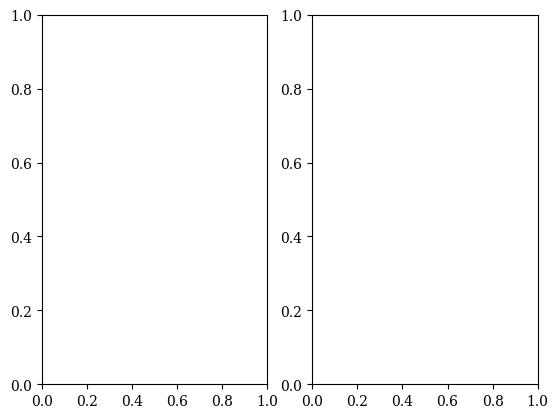

In [30]:
fig, axes = plt.subplots(1,2)

In [31]:
axes

array([<Axes: >, <Axes: >], dtype=object)

<Axes: xlabel='num_pixels', ylabel='num_lines'>

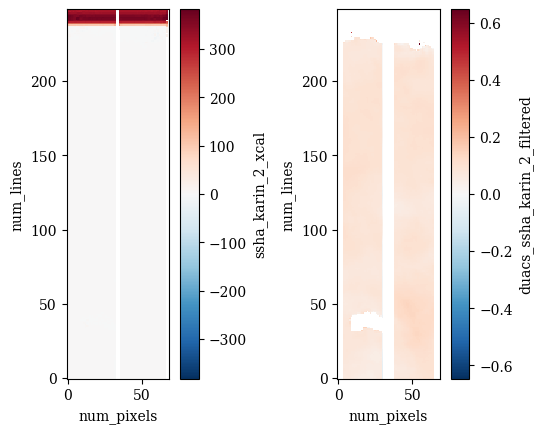

In [35]:

_plot(*(_dsm[v] for v in ["ssha_karin_2_xcal", "duacs_ssha_karin_2_filtered"]))

---

# compute mean and std

In [14]:
# apply mask and take median

mask = (ds["ssha_karin_2_qual"]<50)
variables_ssh = [
 'duacs_ssha_karin_2',
 'duacs_ssha_karin_2_calibrated',
 'duacs_ssha_karin_2_filtered',
 'duacs_ssha_karin_2_oi',
 'duacs_ssha_karin_2_unet_gomez',
 'ssha_karin_2',
]
for v in variables_ssh:
    ds[v] = ds[v].where(mask)


# should be a mean instead but rigorous masking
dsm = ds.median("cycle_number").compute()

dss = (ds-dsm).std()

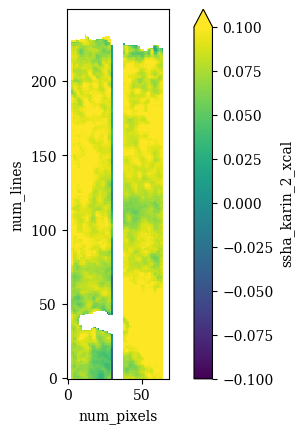

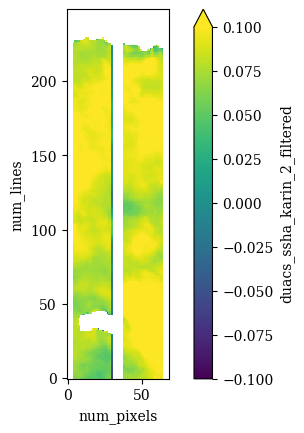

In [15]:
_ds = dsm
#_plot(_ds["duacs_ssha_karin_2"], vmin=-.1, vmax=.1)
_plot(_ds["ssha_karin_2_xcal"], vmin=-.1, vmax=.1)
_plot(_ds["duacs_ssha_karin_2_filtered"], vmin=-.1, vmax=.1)

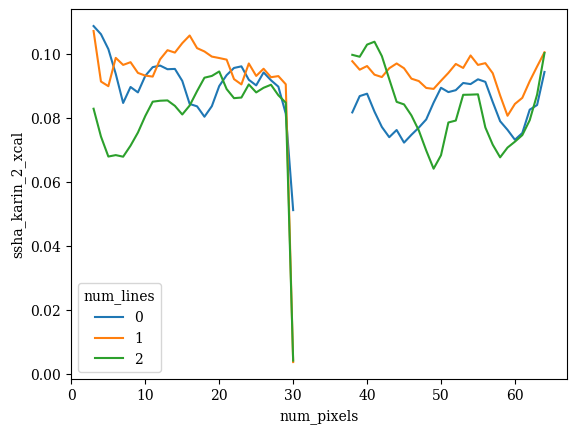

In [22]:
#fig, ax = plt
#for n = [100, 150, 200]:
_ds["ssha_karin_2_xcal"].sel(num_lines=[100,150,200]).plot(hue="num_lines")

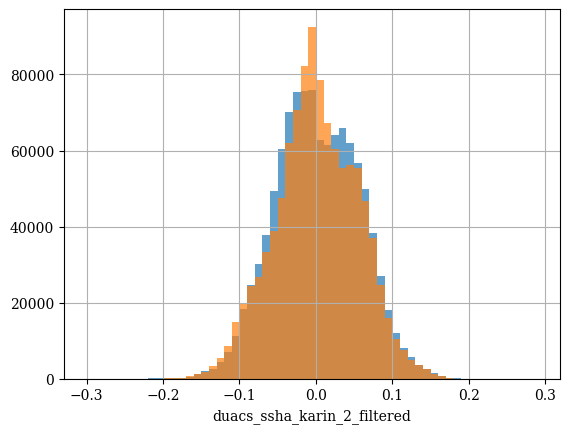

In [18]:
fig, ax = plt.subplots(1,1)
for v in ["ssha_karin_2_xcal", "duacs_ssha_karin_2_filtered"]:
    (ds[v] - dsm[v]).plot.hist(ax=ax,bins=np.arange(-.3, .3,.01), alpha=.7);
ax.grid()

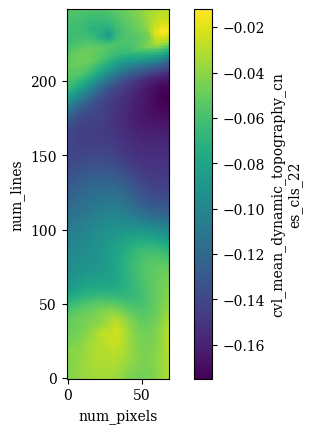

In [21]:
mdt = dsm["cvl_mean_dynamic_topography_cnes_cls_22"]
#mdt_bis = dsm["cvl_mean_sea_surface_cnes_22_hybrid"]
_plot(mdt)

In [ ]:
show mdt + mean circulation

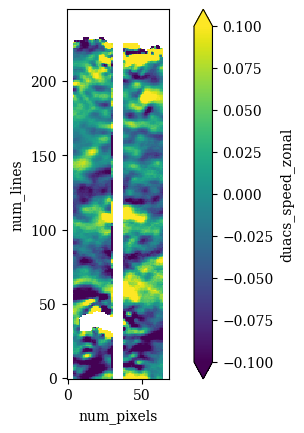

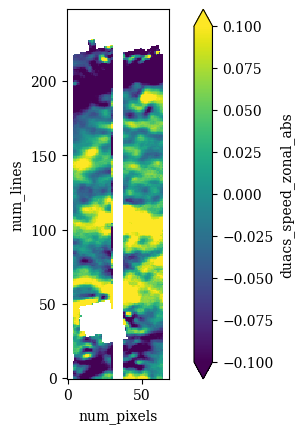

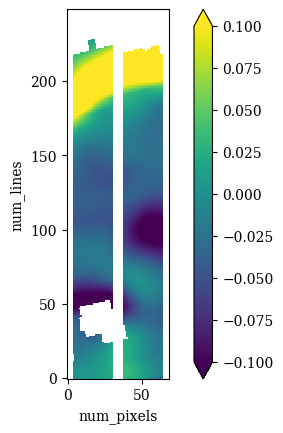

In [25]:
_ds = dsm
_plot(_ds["duacs_speed_zonal"], vmin=-.1, vmax=.1)
_plot(_ds["duacs_speed_zonal_abs"], vmin=-.1, vmax=.1)
_plot(_ds["duacs_speed_zonal"] - _ds["duacs_speed_zonal_abs"], vmin=-.1, vmax=.1)

In [27]:
da = dsm["ssha_karin_2_xcal"]
da = da.sel(num_lines=slice(150,None))
da = da.stack(point=("num_lines", "num_pixels"))
da = da.where( ~np.isnan(da), drop=True )

In [35]:
field = da.values
deg2rad = np.pi/180
x = da.longitude.values * deg2rad
y = da.latitude.values * deg2rad
bin_center, gamma = gs.vario_estimate((x, y), field, latlon=True, geo_scale="KM_SCALE")

Stable(dim=2, var=0.000582, len_scale=0.00893, nugget=8.02e-05, alpha=0.977)


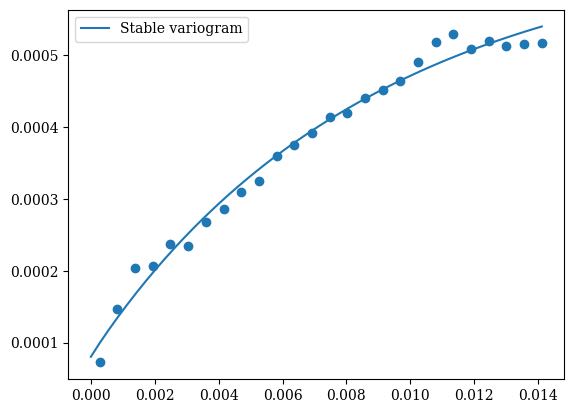

In [32]:
# fit the variogram with a stable model. (no nugget fitted)
fit_model = gs.Stable(dim=2)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# output
ax = fit_model.plot(x_max=max(bin_center))
ax.scatter(bin_center, gamma)
print(fit_model)

In [33]:
fit_model.calc_integral_scale()

0.009024195883531363

In [34]:
vario_estimate?

Object `vario_estimate` not found.


In [26]:
gs.vario_estimate?

Signature:
gs.vario_estimate(
    pos,
    field,
    bin_edges=None,
    sampling_size=None,
    sampling_seed=None,
    estimator='matheron',
    latlon=False,
    direction=None,
    angles=None,
    angles_tol=0.39269908169872414,
    bandwidth=None,
    no_data=nan,
    mask=False,
    mesh_type='unstructured',
    return_counts=False,
    mean=None,
    normalizer=None,
    trend=None,
    fit_normalizer=False,
    geo_scale=1.0,
    **std_bins,
)
Docstring:
Estimates the empirical variogram.

The algorithm calculates following equation:

.. math::
   \gamma(r_k) = \frac{1}{2 N(r_k)} \sum_{i=1}^{N(r_k)} (z(\mathbf x_i) -
   z(\mathbf x_i'))^2 \; ,

with :math:`r_k \leq \| \mathbf x_i - \mathbf x_i' \| < r_{k+1}`
being the bins.

Or if the estimator "cressie" was chosen:

.. math::
   \gamma(r_k) = \frac{\frac{1}{2}\left(\frac{1}{N(r_k)}\sum_{i=1}^{N(r_k)}
   \left|z(\mathbf x_i) - z(\mathbf x_i')\right|^{0.5}\right)^4}
   {0.457 + 0.494 / N(r_k) + 0.045 / N^2(r_k)} \; ,

with :ma

In [97]:
import pymc

In [23]:
xr.concat?

Signature:
xr.concat(
    objs,
    dim,
    data_vars: 'T_DataVars' = 'all',
    coords='different',
    compat: 'CompatOptions' = 'equals',
    positions=None,
    fill_value=<NA>,
    join: 'JoinOptions' = 'outer',
    combine_attrs: 'CombineAttrsOptions' = 'override',
)
Docstring:
Concatenate xarray objects along a new or existing dimension.

Parameters
----------
objs : sequence of Dataset and DataArray
    xarray objects to concatenate together. Each object is expected to
    consist of variables and coordinates with matching shapes except for
    along the concatenated dimension.
dim : Hashable or Variable or DataArray or pandas.Index
    Name of the dimension to concatenate along. This can either be a new
    dimension name, in which case it is added along axis=0, or an existing
    dimension name, in which case the location of the dimension is
    unchanged. If dimension is provided as a Variable, DataArray or Index, its name
    is used as the dimension to concatenate along a